# Case Study - Leads Scoring

# Problem Statement
An education company named X Education sells online courses to industry professionals. The company markets its courses on various platforms also X Education gets leads through past referrals. The typical lead conversion rate at X education is around 30% although X Education gets a lot of leads, its lead conversion rate is very poor.
The company has appointed us help them in selecting the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein we need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO has given a ballpark of the target lead conversion rate to be around 80%.<br>

## Goals of the Case Study
There are quite a few goals for this case study:
- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
- There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.


##### Importing Necessary Libraries:

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
#Importing required packages

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
#Importing Plot libraries:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

from sklearn.metrics import precision_score, recall_score

from sklearn.metrics import precision_recall_curve

##### Importing the data:

In [2]:
leads = pd.read_csv("Leads.csv")

In [3]:
leads.shape

(9240, 37)

In [4]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### Calculating the percentage of missing values in each column

In [6]:
#Calculating the percentage of missing values in each column
missing_values = round(leads.isnull().sum()/len(leads)*100,2).sort_values(ascending=False)
missing_values

Lead Quality                                     51.59
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
Asymmetrique Profile Index                       45.65
Tags                                             36.29
Lead Profile                                     29.32
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
How did you hear about X Education               23.89
Specialization                                   15.56
City                                             15.37
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
Receive More Updates About Our Courses            0.00
I agree to

### Handling missing values and columns where the value is 'Select'

#### Dropping columns that has more than 40% null values

In [7]:
for col in leads:
    if 100*(leads[col].isnull().sum()/len(leads)) > 40:
        leads.drop(col,axis=1,inplace=True)

In [8]:
# Rechecking the dataframe share after dropping the columns
leads.shape

(9240, 32)

#### Handling the value 'Select' in certain columns. This value is as good as 'Null' so assigning 'Not Selected' to both 'Select' and 'NaN' values

In [9]:
for col in leads:
    if 'Select'  in leads[col].unique():
        leads[col] = leads[col].apply(lambda x :'Not Selected' if x == 'Select' else x)
        leads[col].fillna('Not Selected',inplace=True)

__Checking if all the 'Select' values have been handled__

In [10]:
for col in leads:
    if 'Select'  in leads[col].unique():
        print(col,'\n',leads[col].unique())

In [11]:
#Calculating the percentage of missing values in each column
missing_values = round(leads.isnull().sum()/len(leads)*100,2).sort_values(ascending=False)
## Display columns that have more than 0 null values
missing_values[missing_values>0]

Tags                                             36.29
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
dtype: float64

#### Column: 'Tags'
_Analyzing the values of Tags column_

In [12]:
leads.Tags.value_counts()

Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with EINS                                     12
Lost to Others

__Imputing the value null value to 'Other' in 'Tags' column as adding a any other value might give a different meaning to the tag.__

In [13]:
leads.Tags.fillna('Others',inplace=True)

#### Column: 'What matters most to you in choosing a course'
_Analzing the values of the column._


In [14]:
leads['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

__Imputing the null value with the value 'Other' in 'What matters most to you in choosing a course' columns as the Other seems like a the best option since the reason is not specified. And 'Other' is already a value used in the column__

In [15]:
leads['What matters most to you in choosing a course'].fillna('Other',inplace=True)

#### Column: 'What is your current occupation'
_Analyzing the values of the column_

In [16]:
leads['What is your current occupation'].value_counts()

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

__Imputing the null values with the value'Other' in 'What is your current occupation' columns as the Other seems like a the best option since the occupation is not specified. And 'Other' is already a value used in the column__

In [17]:
leads['What is your current occupation'].fillna('Other',inplace=True)

#### Column: 'Country'
_Analyzing the column values_


In [18]:
leads.Country.value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malaysia      

In [19]:
#Mode value in Country column
leads.Country.mode()

0    India
dtype: object

__Imputing value 'India' for nulls in the Country column as 'India' is the mode value__

In [20]:
leads.Country.fillna(leads.Country.mode()[0],inplace=True)

#### Column: 'Page Views Per Visit'
_Analyzing the column values_

In [21]:
leads['Page Views Per Visit'].value_counts()

0.00    2189
2.00    1795
3.00    1196
4.00     896
1.00     651
        ... 
3.43       1
2.56       1
6.33       1
1.64       1
2.08       1
Name: Page Views Per Visit, Length: 114, dtype: int64

In [22]:
leads['Page Views Per Visit'].mode()

0    0.0
dtype: float64

__Imputing the value 0.0 for null values in 'Page Views Per Visit' column as it is the mode value.__

In [23]:
leads['Page Views Per Visit'].fillna(leads['Page Views Per Visit'].mode()[0],inplace=True)

#### Column:'TotalVisits'
_Analzing the column values_

In [24]:
leads['TotalVisits'].value_counts()

0.0      2189
2.0      1680
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
21.0        6
23.0        6
24.0        5
25.0        5
27.0        5
22.0        3
29.0        2
28.0        2
26.0        2
141.0       1
55.0        1
30.0        1
43.0        1
74.0        1
41.0        1
54.0        1
115.0       1
251.0       1
32.0        1
42.0        1
Name: TotalVisits, dtype: int64

In [25]:
leads['TotalVisits'].mode()

0    0.0
dtype: float64

__Imputing the value 0.0 for null values in 'TotalVisits' column as it is the mode value.__

In [26]:
leads['TotalVisits'].fillna(leads['TotalVisits'].mode()[0],inplace=True)

#### Column: 'Last Activity'
_Analzing the column values_

In [27]:
leads['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [28]:
leads['Last Activity'].mode()

0    Email Opened
dtype: object

__Imputing the value 'Email Opened' for null values in 'Last Activity' column as it is the mode value.__

In [29]:
leads['Last Activity'].fillna(leads['Last Activity'].mode()[0],inplace=True)

#### Column: 'Lead Source'
_Analyzing the values_

In [30]:
leads['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [31]:
leads.Specialization.value_counts()

Not Selected                         3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

__Imputing the value 'Google' for null values in 'Lead Source' column as it is the mode value.__

In [32]:
leads['Lead Source'].fillna(leads['Lead Source'].mode()[0],inplace=True)

In [33]:
leads.shape

(9240, 32)

### Re-checking null values after Null Value handling

__No null values are present in the data__

In [34]:
leads.isnull().sum()

Prospect ID                                      0
Lead Number                                      0
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
How did you hear about X Education               0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Magazine                                         0
Newspaper Article                                0
X Education Forums             

## Performing EDA 

In [35]:
leads.head(5)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,Not Selected,Not Selected,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Not Selected,Not Selected,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Not Selected,Not Selected,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Not Selected,Not Selected,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Not Selected,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Potential Lead,Mumbai,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Not Selected,Mumbai,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Not Selected,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Not Selected,Mumbai,No,No,Modified


In [36]:
ctgry_features = []
cnts_features = []

## Getting features that have categorical values
for col in leads.columns:
    if leads[col].dtype == 'object':
        ctgry_features.append(col)
    else:
        cnts_features.append(col)

#dropping 'Prospect ID' since it is unique index
ctgry_features.remove('Prospect ID')

#dropping 'Lead Number' since it is unique index
cnts_features.remove('Lead Number')

In [37]:
print(ctgry_features)

['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


In [38]:
print(cnts_features)

['Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


#### Plotting the categorical features

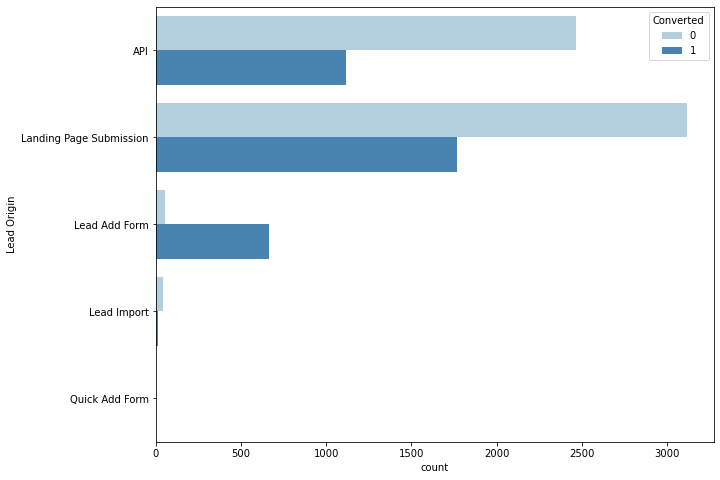

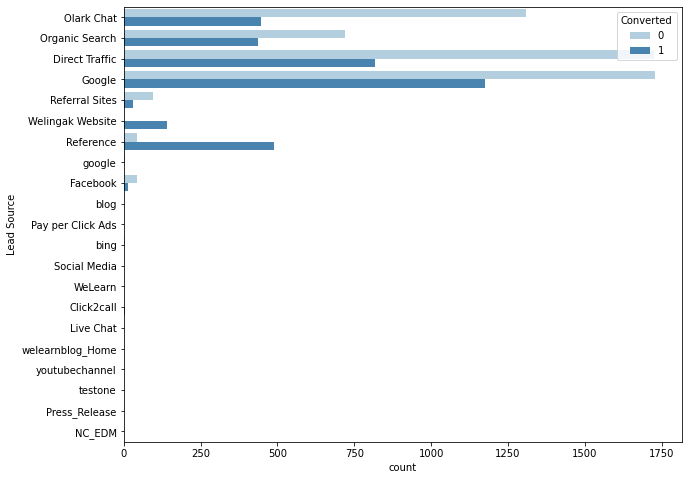

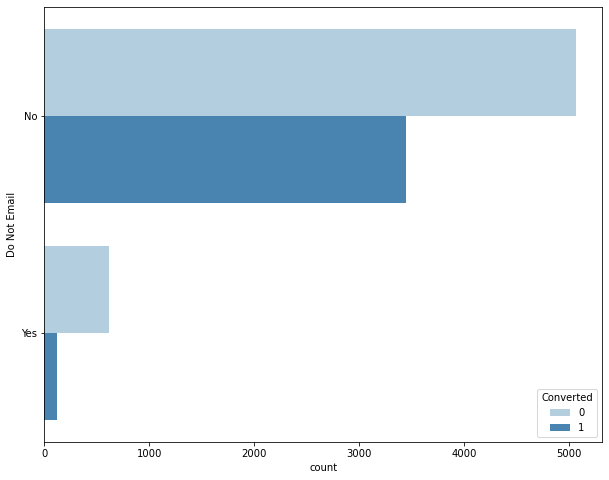

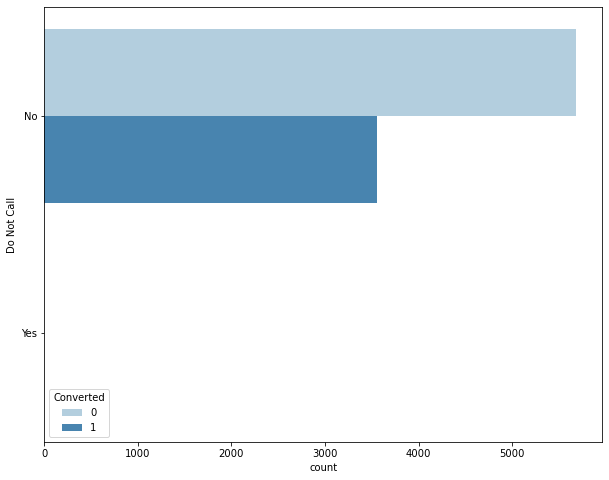

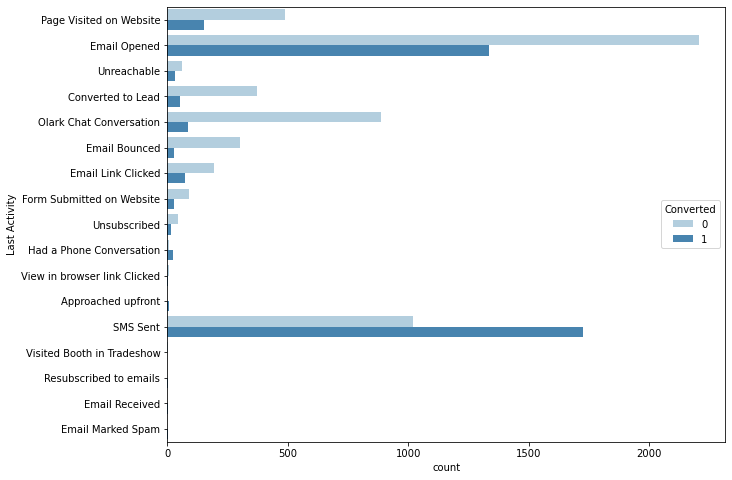

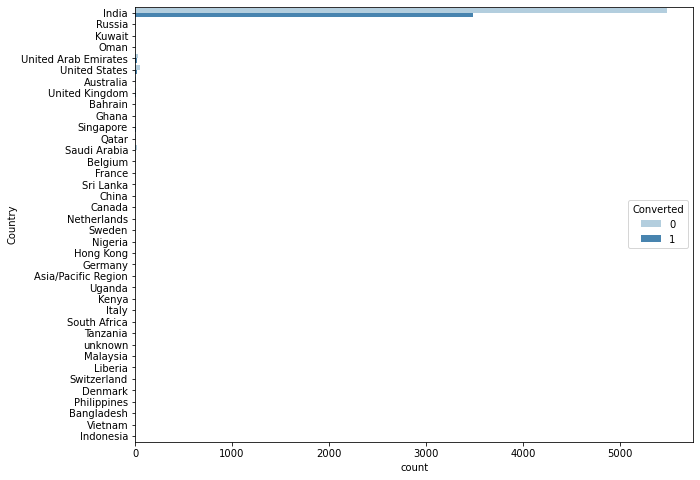

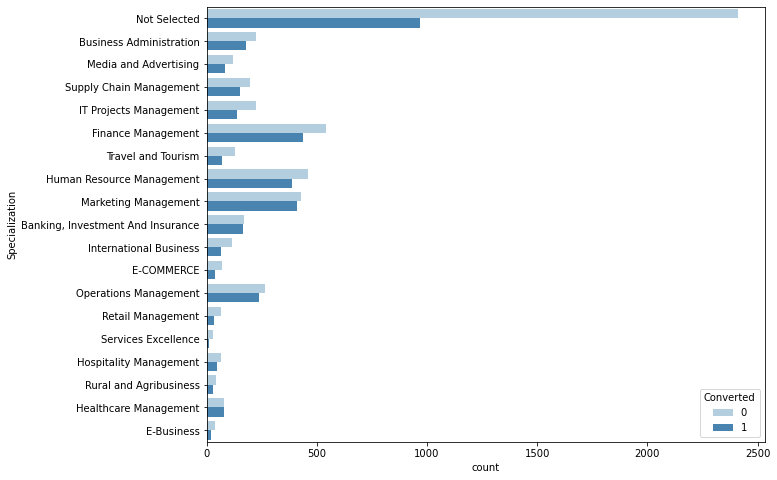

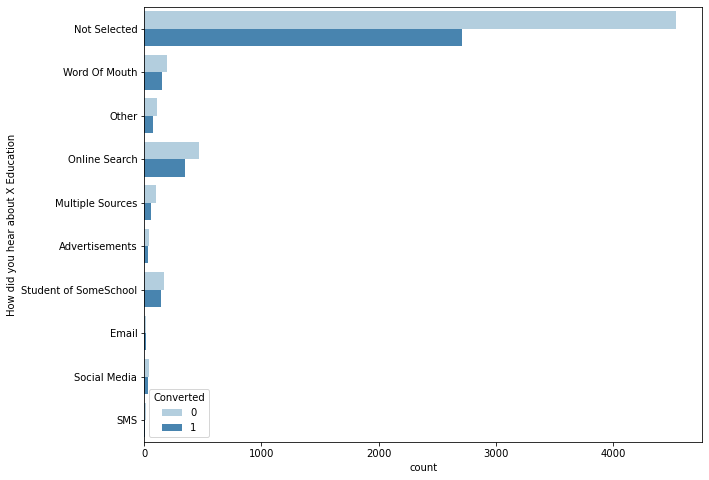

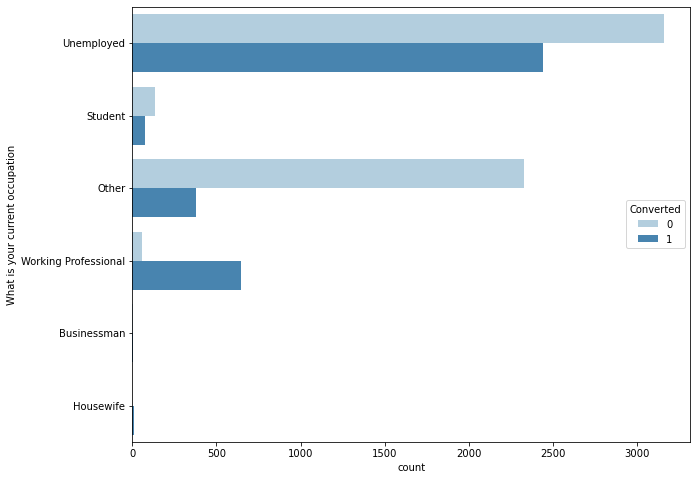

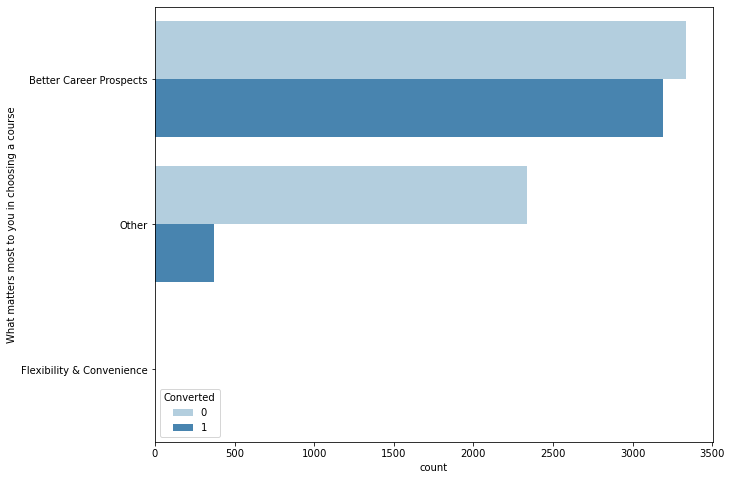

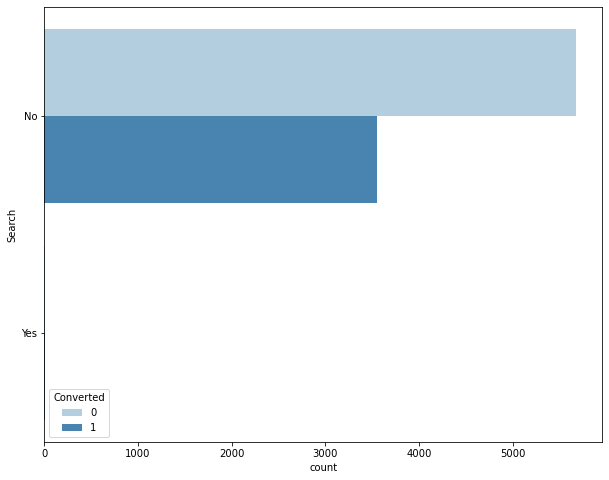

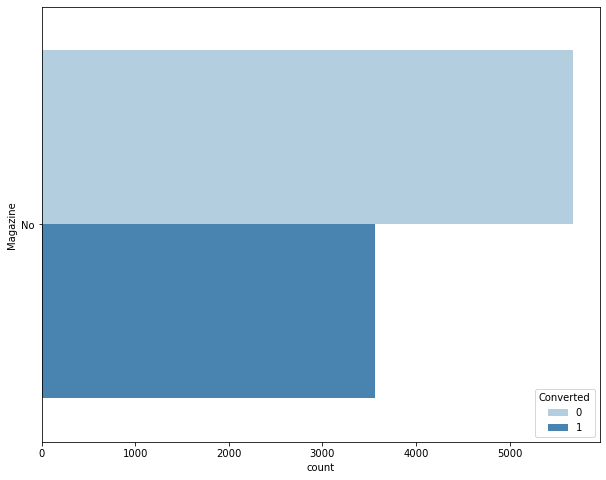

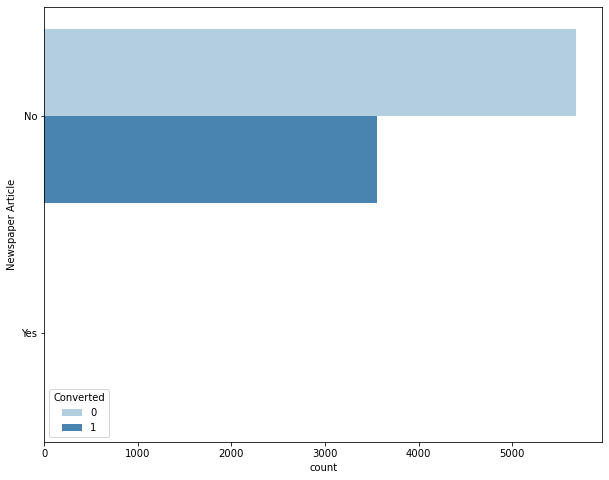

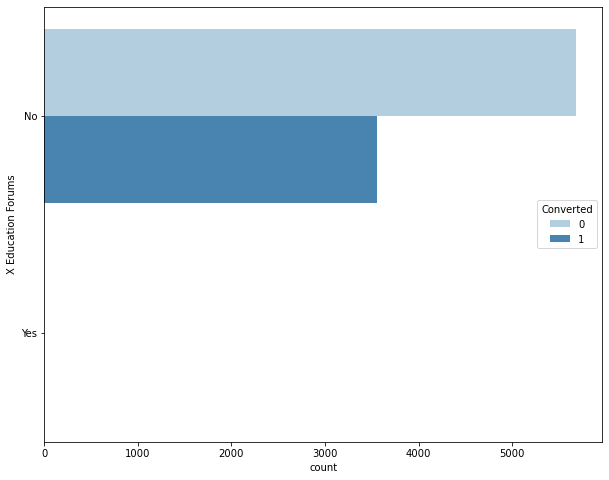

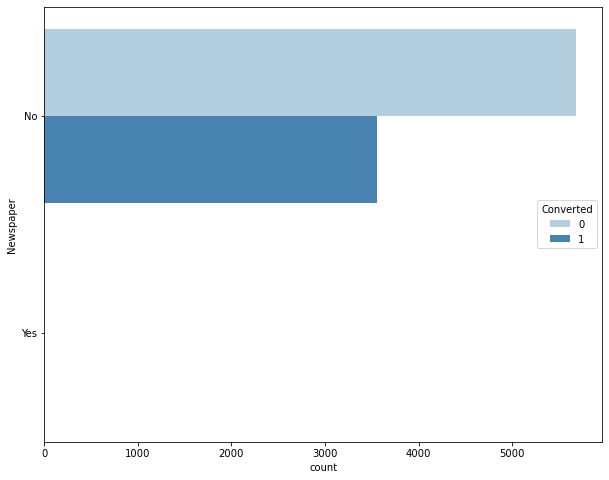

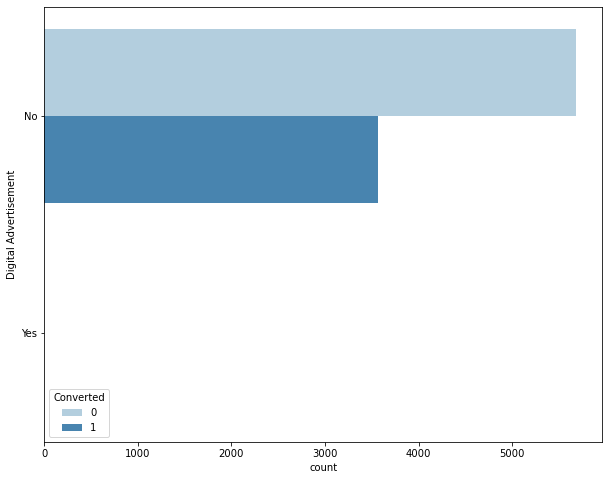

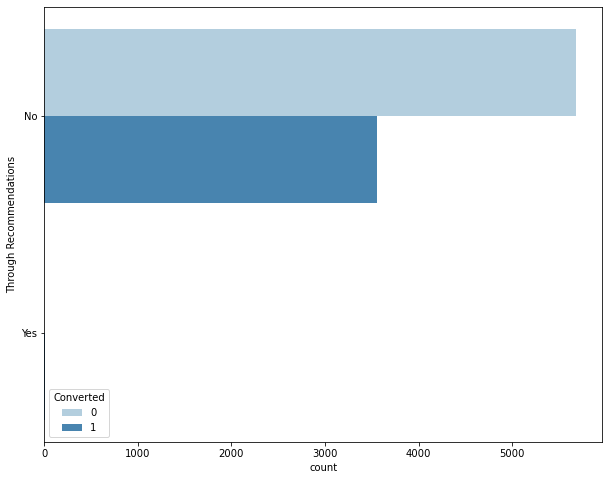

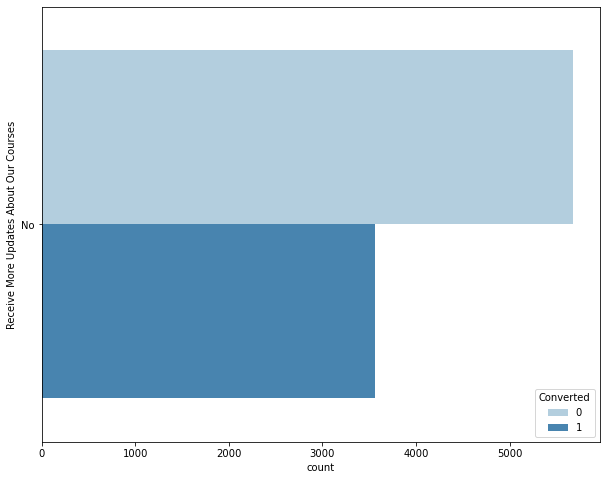

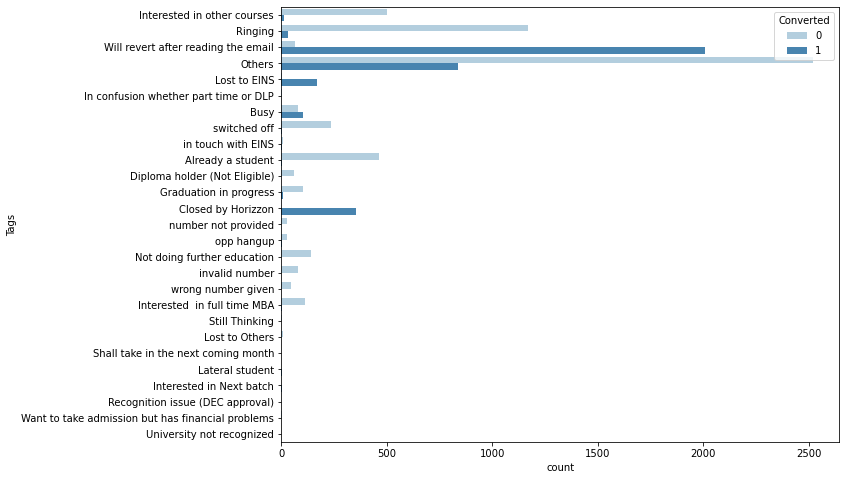

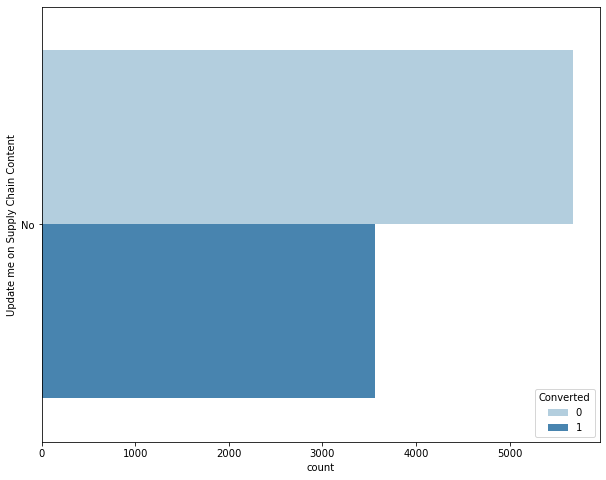

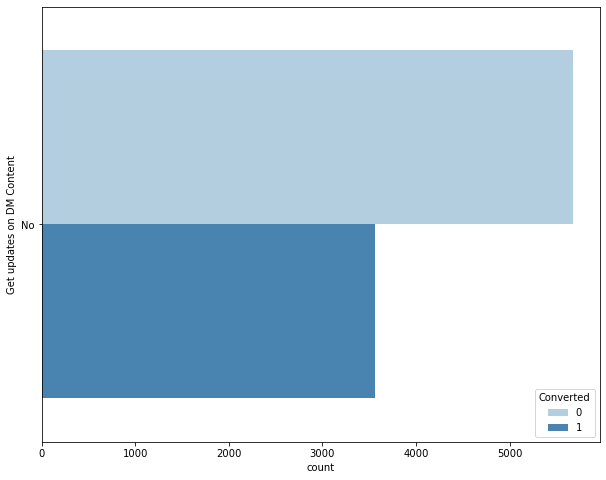

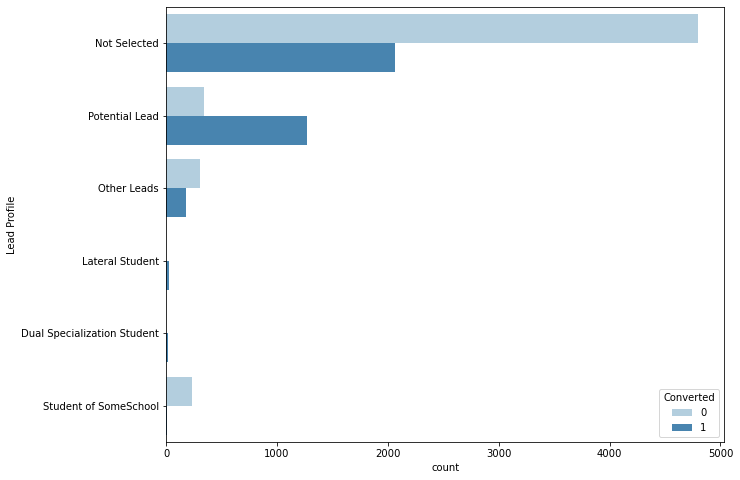

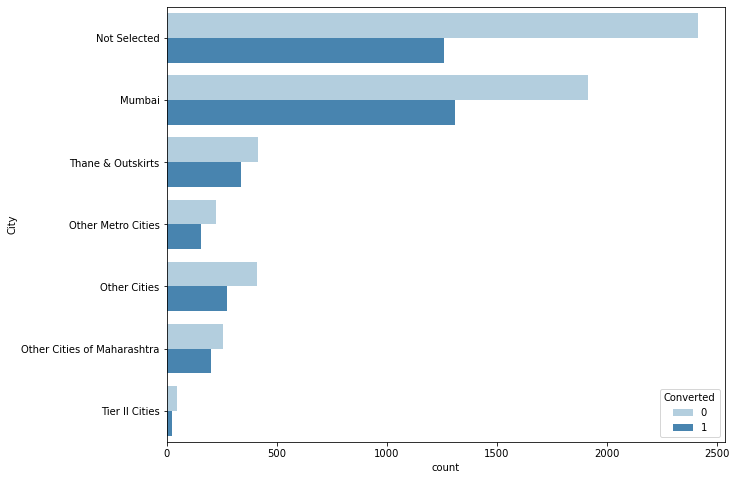

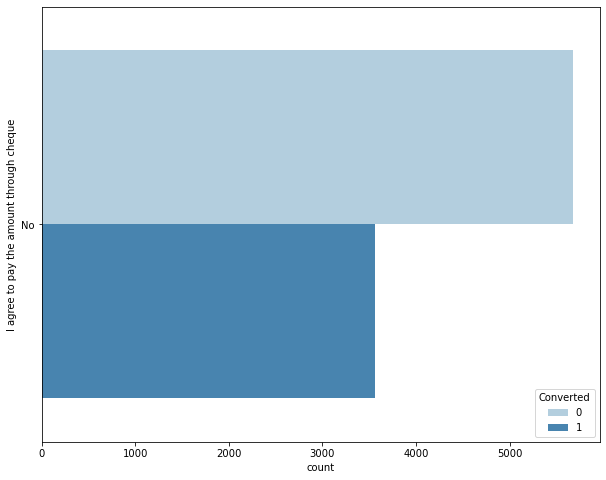

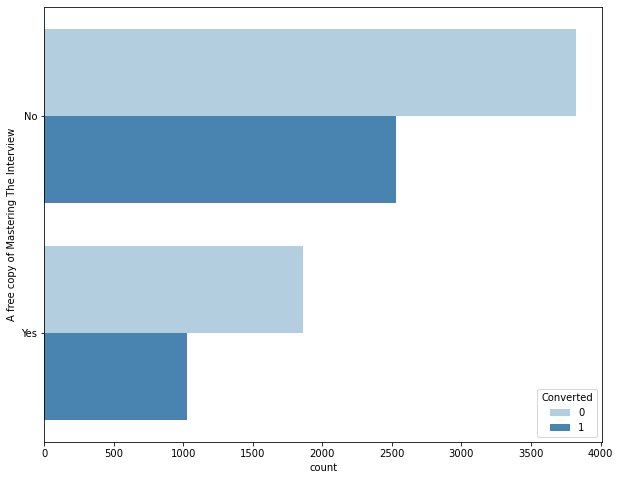

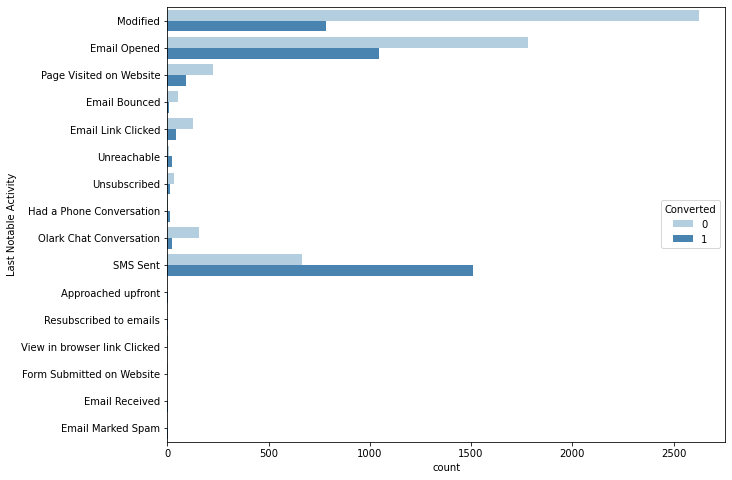

In [39]:
for i in ctgry_features:
    plt.figure(figsize=(10,8))
    sns.countplot(y=i,hue='Converted',data=leads,palette ="Blues")
    plt.show()

### Observed that the values on column 'Lead Source' has Google and google as values.

In [40]:
leads['Lead Source'].value_counts()

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [41]:
# Correcting the value to 'Google'
col  = 'Lead Source'
for col in leads:
    if 'google'  in leads[col].unique():
        leads[col] = leads[col].apply(lambda x :'Google' if x == 'google' else x)   

In [42]:
# Value handled
leads['Lead Source'].value_counts()

Google               2909
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: Lead Source, dtype: int64

## Insights from EDA

### Below columns show some insights into Lead Conversion
__Lead Orign:__ Highest conversion in 'Landing Page Submission' followed by 'API'\
__Lead Source:__ Highest conversion from 'Google' followed by 'Direct Traffic'\
__Last Activity:__ Conversion is hightest amonst students who has 'SMS sent'\
__Country:__ Highest conversion has happened in India\
__Specialization:__ Highest conversion is seen for 'Not selected', this could mean these customers were not employed previously.\
__What is the current occupation:__ This data seems shows the maximum number of conversion happened in 'Unemployed' category\
__Tags:__ Highest conversion is seen in for 'Will revert after reading the email' option.\
__City__: Mumbai has the highest conversion rate.\
__Last Notable Activity__: Highest conversion is seen for SMS sent and Email Opened activities.


### Below columns can be dropped. The reasons are provided against each column:
__Do Not Call:__ Only 2 records opted for Yes and rest opted No for column 'Do not call' . Therefore this column will have all the values as 'No' and this column can be dropped\
__Country :__ Since the number of leads and also conversion percentage across all other countries put together is low compared to India, we can drop the countries column.\
__All the below columns have either only one value or large percentage of values are same.__\
__Search__\
__Magazine__\
__Newspaper Article__\
__X Education Forums__\
__Newspaper__\
__Digital Advertisement__\
__Through Recommendations__\
__Receive More Updates About Our Courses__\
__Update me on Supply Chain Content__\
__Get updates on DM Content__\
__I agree to pay the amount through cheque__

In [43]:
## Plotting the continuous variables

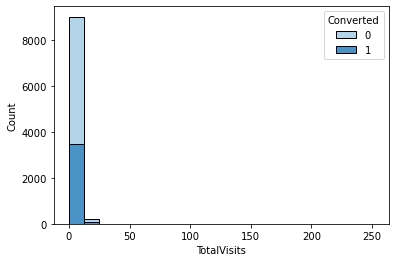

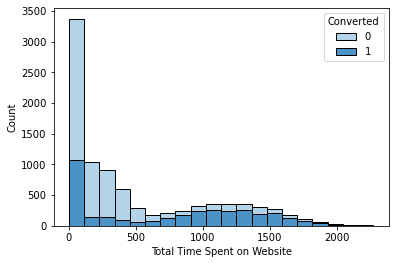

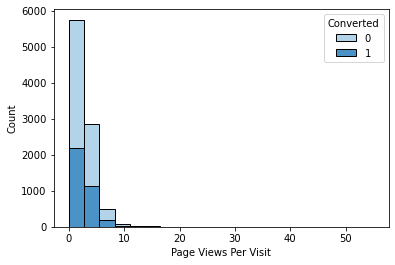

In [44]:
for i in cnts_features:
    if i != 'Converted':
        sns.histplot(data = leads,x = i,hue = 'Converted',alpha = 0.9,multiple = 'stack',bins=20,palette='Blues')
        plt.show()

### Insights dervied from numerical data

__No significant insights for lead conversion can be derived from numerical data, in terms of conversion of leads.__

### Dropping columns based on above analysis

#### Drop 'Prospect ID' since Lead Number is unique

In [45]:
leads['Prospect ID'].nunique()

9240

In [46]:
leads['Lead Number'].nunique()

9240

In [47]:
leads.drop('Prospect ID',axis=1,inplace=True)

In [48]:
#Setting 'Lead Number' as index

In [49]:
leads.set_index('Lead Number',inplace=True)

__Dropping columns that have only one value 'No' in all the rows or has single value that has more the 99% occurence.__

In [50]:
## get columns that have only one value
single_val_cols = []
for col in leads.columns:
    if col != 'Lead Number':
        if (leads[col].nunique() == 1)|(100*(leads[col].value_counts()/len(leads)).sort_values(ascending=False)[0] > 99):
            print('Column:',col,' -- Values: ',leads[col].unique(),' and percentage of :',leads[col].value_counts().sort_values(ascending=False).index[0], ' is ',round((100*(leads[col].value_counts()/len(leads)).sort_values(ascending=False)[0]),2))
            #print('Column: ',col,'--> Values are: ',leads[col].unique(),'% of :',leads[col].value_counts().sort_values(ascending=False)[0], ' is ',(100*(leads[col].value_counts()/len(leads)).sort_values(ascending=False)[0]))
            single_val_cols.append(col)

Column: Do Not Call  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.98
Column: Search  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.85
Column: Magazine  -- Values:  ['No']  and percentage of : No  is  100.0
Column: Newspaper Article  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.98
Column: X Education Forums  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.99
Column: Newspaper  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.99
Column: Digital Advertisement  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.96
Column: Through Recommendations  -- Values:  ['No' 'Yes']  and percentage of : No  is  99.92
Column: Receive More Updates About Our Courses  -- Values:  ['No']  and percentage of : No  is  100.0
Column: Update me on Supply Chain Content  -- Values:  ['No']  and percentage of : No  is  100.0
Column: Get updates on DM Content  -- Values:  ['No']  and percentage of : No  is  100.0
Column: I agree to pay the amount through che

In [51]:
leads.drop(single_val_cols,axis=1,inplace=True)

__Dropping Country column. Since more than 96% of the leads are from India__

In [52]:
leads.Country.value_counts()

India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malaysia      

In [53]:
100*leads.Country.value_counts()[0]/len(leads)

96.89393939393939

In [54]:
leads.drop('Country',axis=1,inplace=True)

#### Converting Yes and No values in colums to 1 and 0 respectively

In [55]:
## Getting columns that have 'Yes' or 'No' values

binary_cols = []

for col in leads.columns:
    if leads[col].unique().any() in ['Yes','No']:
        binary_cols.append(col)
        
for cols in binary_cols:
    print(cols,' \n****************\n',leads[cols].value_counts(),"\n")

Do Not Email  
****************
 No     8506
Yes     734
Name: Do Not Email, dtype: int64 

A free copy of Mastering The Interview  
****************
 No     6352
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64 



In [56]:
def binary_mapping(x):
    return x.map({'Yes':1,'No':0})
    
leads[binary_cols] = leads[binary_cols].apply(binary_mapping)

### Checking for outliers in the retained numerical columns

In [57]:
leads.describe(percentiles = [0.0,0.05,0.10,0.25,0.50,0.75,0.8,0.9,0.95,0.99])

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview
count,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000
mean,0.079437,0.385390,3.394156,487.698268,2.327787,0.312554
std,0.270435,0.486714,4.836682,548.021466,2.164258,0.463559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000
50%,0.000000,0.000000,3.000000,248.000000,2.000000,0.000000
75%,0.000000,1.000000,5.000000,936.000000,3.000000,1.000000


In [58]:
cnts_features

['Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit']

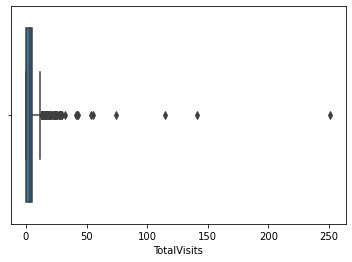

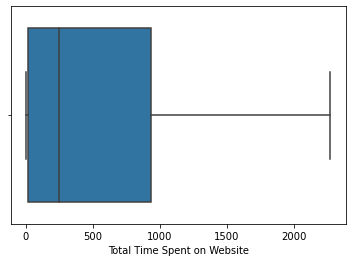

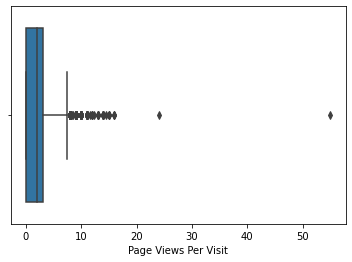

In [59]:
for feature in cnts_features:
    if feature != 'Converted':
        sns.boxplot(leads[feature])
        plt.show()

__'TotalVisits','Total Time Spent on Website' and 'Page Views Per Visit' have outliers but we will not drop any rows as this info may be relevant for analysis__

### Analysing  columns with categorical values to consolidate the categories based on value relevance or to remove columns that are not relevant.

In [60]:
ctgry_cols = ['Lead Origin','Lead Source','Last Activity','Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course','Tags','Lead Profile','City','Last Notable Activity']

In [61]:
for col in ctgry_cols:
    print('Column: ',col,'\n*******\n',leads[col].value_counts(),'\n__________________\n')

Column:  Lead Origin 
*******
 Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64 
__________________

Column:  Lead Source 
*******
 Google               2909
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: Lead Source, dtype: int64 
__________________

Column:  Last Activity 
*******
 Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Vis

### Based on the values in each of the columns


__1.Following values in 'Lead Source' column can be consolidate into 'Others' since they are less in number and are not significant individually.__\
Facebook--               55\
bing      --              6\
google    --              5\
Click2call      --        4\
Press_Release   --        2\
Social Media  --          2\
Live Chat   --            2\
youtubechannel --         1\
testone   --              1\
Pay per Click Ads --      1\
welearnblog_Home   --     1\
WeLearn     --            1\
blog   --                 1\
NC_EDM     --             1

__2.Following values in 'Last Activity' column can be consolidate into 'Others' since they are less in number and are not significant individually.__\ 

Approached upfront --                9\
View in browser link Clicked --      6\
Email Received           --          2\
Email Marked Spam         --         2\
Visited Booth in Tradeshow --        1\
Resubscribed to emails       --      1\

__2.What matters most to you in choosing a course : This column can be dropped as the only significant value is 'Better Career Prospects'. There are no other meaningful values in the column__\
__3.Tags: Tags column can be removed as it is assigned to the customer as status of the lead__\
__4.Last Notable Activity: This column can be dropped as it has the same meaning as the 'Last Activity' column as mentioned in the data dictionary.__


In [62]:
## Replacing insignificant values in 'Lead Source' column to 'Others'

In [63]:
leads['Lead Source'].replace(['Facebook','bing','Click2call','Press_Release','Social Media','Live Chat','youtubechannel','testone','Pay per Click Ads','welearnblog_Home','WeLearn','blog','NC_EDM'],'Others',inplace=True)

In [64]:
leads['Last Activity'].replace(['Approached upfront','View in browser link Clicked','Email Received','Email Marked Spam','Visited Booth in Tradeshow','Resubscribed to emails'],'Others',inplace=True)

In [65]:
leads[(leads['Lead Source'] == 'Others') | (leads['Last Activity'] == 'Others')]

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Profile,City,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,,,,,,,
659833,API,Olark Chat,0,0,0.0,0,0.00,Others,Finance Management,Not Selected,Unemployed,Better Career Prospects,Interested in other courses,Other Leads,Not Selected,0,Modified
658432,Lead Add Form,Reference,0,1,0.0,785,0.00,Others,Not Selected,Not Selected,Unemployed,Better Career Prospects,Will revert after reading the email,Not Selected,Not Selected,0,Modified
657311,API,Google,0,0,10.0,11,10.00,Others,Not Selected,Not Selected,Other,Other,Others,Not Selected,Not Selected,0,Modified
654173,Lead Import,Others,0,1,0.0,844,0.00,Email Opened,Not Selected,Not Selected,Unemployed,Better Career Prospects,Will revert after reading the email,Potential Lead,Other Cities of Maharashtra,0,Modified
654174,Lead Import,Others,0,0,0.0,0,0.00,Email Opened,Not Selected,Not Selected,Unemployed,Better Career Prospects,Ringing,Other Leads,Other Cities,0,Email Opened
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588806,Landing Page Submission,Google,0,1,6.0,761,3.00,Others,Human Resource Management,Social Media,Working Professional,Better Career Prospects,Will revert after reading the email,Not Selected,Mumbai,0,Email Received
588479,Landing Page Submission,Others,0,0,3.0,164,3.00,Page Visited on Website,Travel and Tourism,Not Selected,Unemployed,Better Career Prospects,Interested in other courses,Not Selected,Other Cities,1,Modified
587905,Lead Add Form,Reference,1,1,0.0,0,0.00,Others,Human Resource Management,Not Selected,Unemployed,Better Career Prospects,Will revert after reading the email,Potential Lead,Not Selected,0,Email Marked Spam


#### Dropping below columns
__2.What matters most to you in choosing a course : This column can be dropped as the only significant value is 'Better Career Prospects'. There are no other meaningful values in the column__\
__3.Tags: Tags column can be removed as it is assigned to the customer as status of the lead__\
__4.Last Notable Activity: This column can be dropped as it has the same meaning as the 'Last Activity' column as mentioned in the data dictionary.__\

In [66]:
## Dropping columns 'What matters most to you in choosing a course','Last Notable Activity' and 'Tags' for the following reasons
leads.drop(['What matters most to you in choosing a course','Last Notable Activity','Tags'],axis=1,inplace=True)

In [67]:
leads.shape

(9240, 14)

## Creating dummies for the categorical variables.

In [68]:
dummy = pd.get_dummies(leads[['Lead Origin','Lead Source', 'Last Activity','Specialization','How did you hear about X Education','What is your current occupation','Lead Profile','City']],drop_first = True)

In [69]:
dummy

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Not Selected,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_Not Selected,How did you hear about X Education_Online Search,How did you hear about X Education_Other,How did you hear about X Education_SMS,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Profile_Lateral Student,Lead Profile_Not Selected,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool,City_Not Selected,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
660737,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
660728,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
660727,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
660719,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
660681,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579564,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
579546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
579545,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


##### Dropping the source coulum as dummies are created

In [70]:
leads_encoded = leads.drop(['Lead Origin','Lead Source', 'Last Activity','Specialization','How did you hear about X Education','What is your current occupation','Lead Profile','City'],axis=1)

In [71]:
leads_encoded = pd.concat([leads_encoded,dummy],axis=1)

In [72]:
leads_encoded.shape

(9240, 71)

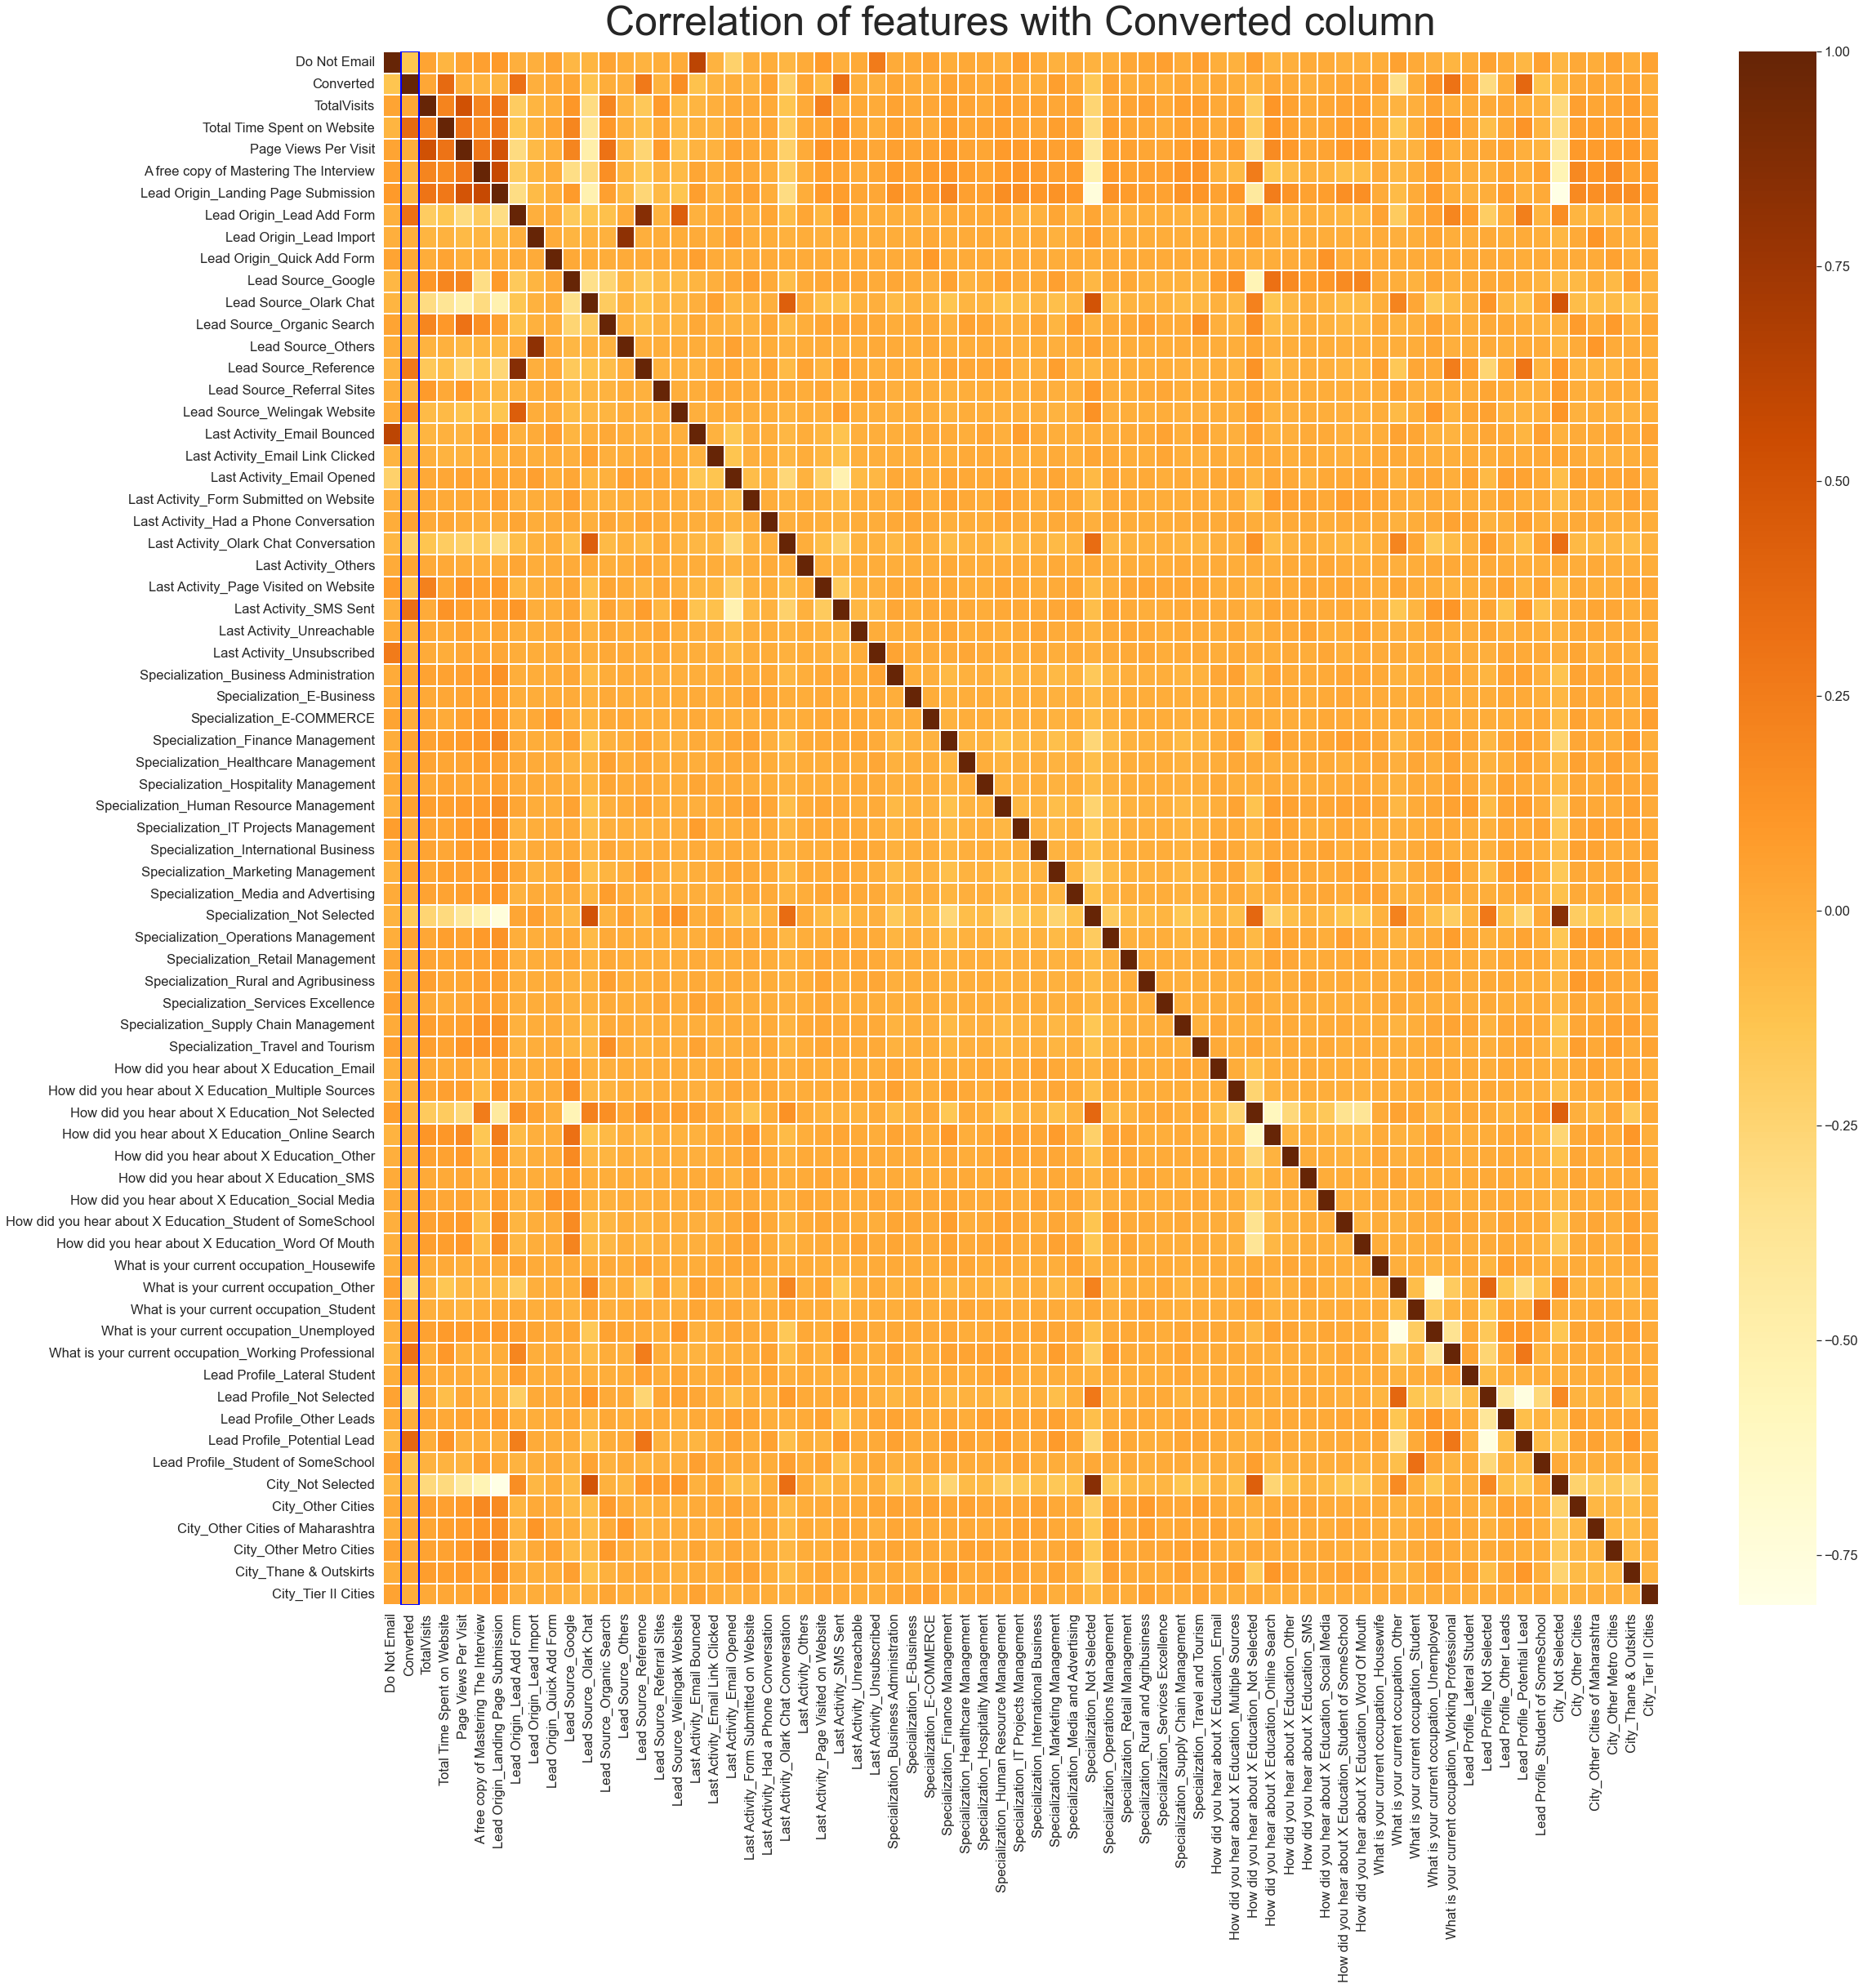

In [73]:
## creating heatmap
plt.figure(figsize = (35,35))
sns.set(font_scale=1.5)
ax = sns.heatmap(leads_encoded.corr(),cmap='YlOrBr',annot_kws={'fontsize':30},linewidths=0.1, linecolor='white')
ax.add_patch(Rectangle((1,0), 1, leads_encoded.shape[1], fill=False, edgecolor='blue', lw=2))
plt.title('Correlation of features with Converted column', fontsize = 50,pad=20) # title with fontsize 20
plt.show()

## Insights from the correlation heatmap

__From the above correlation matrix we can make the below inference__\
__1. The Target Converted is highly correlated to the below features.__\
Total time spent on Website\
Lead Origin_Lead Add Form\
Lead Source_Reference\
Lead Source_Welingak Website\
Last Activity_SMSSent\
What is you current occupation_Working Professional\
Lead Profile_Potential Lead\


## Building the model

### Test train split

In [74]:
## Creating the training and test data
train_df,test_df = train_test_split(leads_encoded,train_size=0.7,random_state=146)

In [75]:
## X_train and y_train
X_train = train_df.drop('Converted',axis=1)
y_train = train_df['Converted']

## X_test and y_test

X_test = test_df.drop('Converted',axis=1)
y_test = test_df['Converted']

In [76]:
X_train.head(2)

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Not Selected,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_Not Selected,How did you hear about X Education_Online Search,How did you hear about X Education_Other,How did you hear about X Education_SMS,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Profile_Lateral Student,Lead Profile_Not Selected,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool,City_Not Selected,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
613099,0,3.0,458,3.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
647994,1,0.0,574,0.0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


### Feature Scaling

In [77]:
scaler = MinMaxScaler()

In [78]:
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [79]:
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Not Selected,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_Not Selected,How did you hear about X Education_Online Search,How did you hear about X Education_Other,How did you hear about X Education_SMS,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Profile_Lateral Student,Lead Profile_Not Selected,Lead Profile_Other Leads,Lead Profile_Potential Lead,Lead Profile_Student of SomeSchool,City_Not Selected,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
613099,0,0.026087,0.203285,0.054545,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
647994,1,0.000000,0.254771,0.000000,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
658071,0,0.017391,0.806036,0.036364,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
592424,0,0.008696,0.175766,0.018182,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
607745,0,0.017391,0.064359,0.036364,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [80]:
X_train.shape

(6468, 70)

In [81]:
## Correlations

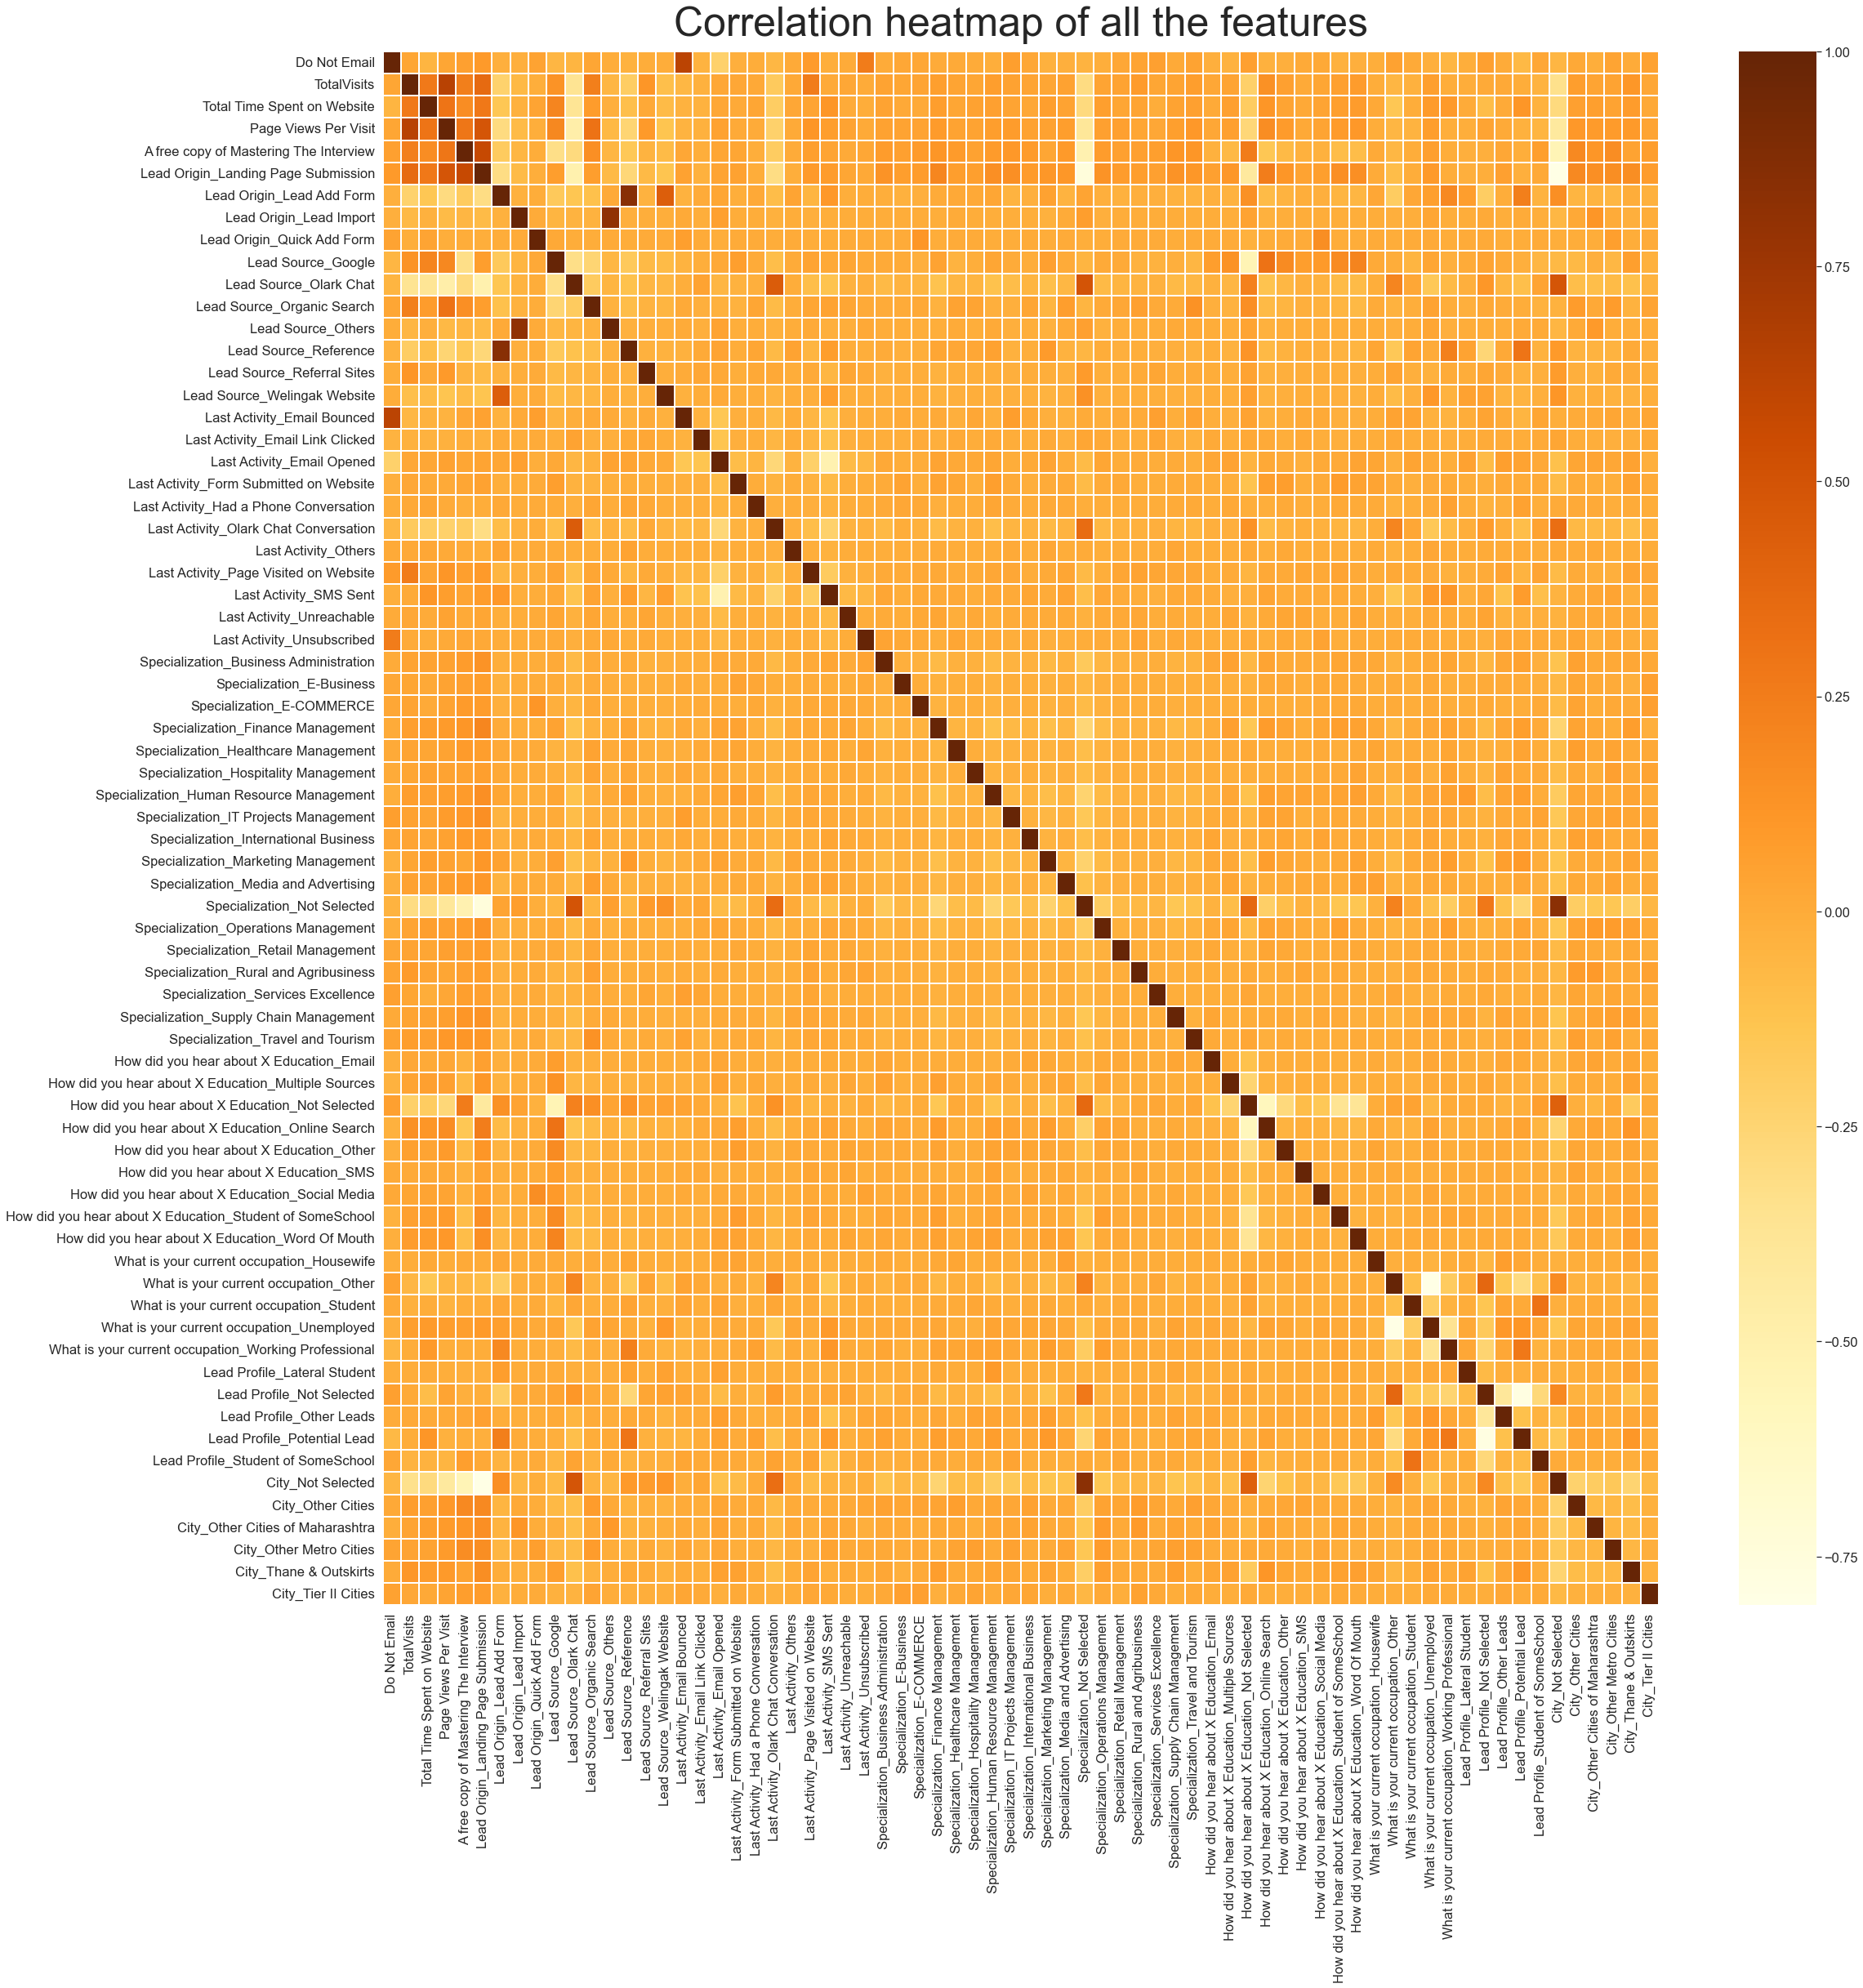

In [82]:
## creating heatmap
plt.figure(figsize = (35,35))
sns.set(font_scale=1.5)
ax = sns.heatmap(X_train.corr(),cmap='YlOrBr',annot_kws={'fontsize':30},linewidths=0.1, linecolor='white')
plt.title('Correlation heatmap of all the features', fontsize = 50,pad=20) # title with fontsize 20
plt.show()

__We can notice that some columns are highly correlated__

__'Lead Source_Other' to 'Lead Origin_Lead Add Form'__\
__'Lead Source_Reference' to 'Lead Origin_Lead Add Form'__\
__'City_Not_selected' to 'Specilization_Not Selected'__


__Not dropping any columns based on the correlations,this will be handled when we use RFE for feature selection.__

## Model building

## Logistic Regression model
#### We are choosing a logistic regression model since the Target variable is binary. Hence this becomes a Classification problem

In [83]:
## Logisting regression model
## let us first create with all the features and see the outcome.

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6397
Model Family:                Binomial   Df Model:                           70
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2429.9
Date:                Wed, 28 Dec 2022   Deviance:                       4859.8
Time:                        15:59:51   Pearson chi2:                 7.85e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       21.6623    2.9e+04      0.001      0.999   -5.68e+04    5.69e+04
Do Not Email                                                -1.3509      0.215     -6.296      0.000      -1.771      -0.930
TotalVisits                                                  5.6602      1.306      4.335      0.000       3.101       8.219
Total Time Spent on Website                                  4.5499      0.173     26.251      0.000       4.210       4.890
Page Views Per Visit                                        -3.0480      1.408     -2.165      0.030      -5.807      -0.289
A free copy of Mastering The Interview                      -0.0299      0.143     -0.208      0.835      -0.311       0.251
Lead Origin_Landing Page Submission                         -0.7815      0.173     -4.518      0.000      -1.121      -0.442
Lead Origin_Lead Add Form                                    2.8954      0.552      5.243      0.000       1.813       3.978
Lead Origin_Lead Import                                     -0.7063      0.866     -0.815      0.415      -2.404       0.991
Lead Origin_Quick Add Form                                  23.0536   1.31e+05      0.000      1.000   -2.57e+05    2.57e+05
Lead Source_Google                                           0.3024      0.129      2.348      0.019       0.050       0.555
Lead Source_Olark Chat                                       1.2619      0.173      7.281      0.000       0.922       1.602
Lead Source_Organic Search                                   0.1437      0.133      1.084      0.278      -0.116       0.403
Lead Source_Others                                           0.5807      0.745      0.780      0.436      -0.879       2.041
Lead Source_Reference                                       -0.2295      0.590     -0.389      0.697      -1.386       0.927
Lead Source_Referral Sites                                  -0.1311      0.368     -0.356      0.721      -0.852       0.590
Lead Source_Welingak Website                                 3.4759      1.151      3.020      0.003       1.220       5.732
Last Activity_Email Bounced                                  0.5302      0.426      1.243      0.214      -0.306       1.366
Last Activity_Email Link Clicked                             0.8232      0.306      2.691      0.007       0.224       1.423
Last Activity_Email Opened                                   1.0969      0.223      4.915      0.000       0.659       1.534
Last Activity_Form Submitted on Website                      0.1685      0.430      0.392      0.695      -0.674       1.011
Last Activity_Had a Phone Conversation                       1.5425      0.623     

__From the above summary we can see that a lot of the features are insignificant based on the p-value. So we need to narrow down our analysis to a few significant features. For this purpose we can use RFE.__

## Feature selection using RFE

In [84]:
logreg = LogisticRegression()
rfe = RFE(logreg,15)
rfe = rfe.fit(X_train,y_train)

In [85]:
rfe.support_

array([ True,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False])

In [86]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 12),
 ('A free copy of Mastering The Interview', False, 56),
 ('Lead Origin_Landing Page Submission', False, 7),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 18),
 ('Lead Origin_Quick Add Form', False, 29),
 ('Lead Source_Google', False, 23),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 39),
 ('Lead Source_Others', False, 22),
 ('Lead Source_Reference', False, 37),
 ('Lead Source_Referral Sites', False, 42),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', False, 40),
 ('Last Activity_Email Link Clicked', False, 13),
 ('Last Activity_Email Opened', False, 10),
 ('Last Activity_Form Submitted on Website', False, 45),
 ('Last Activity_Had a Phone Conversation', False, 9),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Others', False, 2),
 ('Last 

In [87]:
# Columns selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_SMS Sent', 'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Working Professional',
       'Lead Profile_Lateral Student', 'Lead Profile_Not Selected',
       'Lead Profile_Other Leads', 'Lead Profile_Student of SomeSchool'],
      dtype='object')

In [88]:
# The columns that have been dropped by RFE
drop_cols = X_train.columns[~rfe.support_]
drop_cols

Index(['Page Views Per Visit', 'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Others',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Email Opened', 'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website', 'Last Activity_Unreachable',
       'Last Activity_Unsubscribed', 'Specialization_Business Administration',
       'Specialization_E-Business', 'Specialization_E-COMMERCE',
       'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects M

### Creating model with RFE features

#### Model1

In [89]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train[col])),family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2502.1
Date:                Wed, 28 Dec 2022   Deviance:                       5004.3
Time:                        15:59:56   Pearson chi2:                 7.23e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.0420      0.112     -9.288      0.000      -1.262      -0.822
Do Not Email                                            -1.4292      0.167     -8.538      0.000      -1.757      -1.101
TotalVisits                                              4.2386      1.032      4.107      0.000       2.216       6.261
Total Time Spent on Website                              4.5562      0.168     27.091      0.000       4.227       4.886
Lead Origin_Lead Add Form                                3.1555      0.198     15.913      0.000       2.767       3.544
Lead Source_Olark Chat                                   1.5285      0.116     13.121      0.000       1.300       1.757
Lead Source_Welingak Website                             3.4432      1.026      3.355      0.001       1.432       5.455
Last Activity_Olark Chat Conversation                   -1.3123      0.172     -7.612      0.000      -1.650      -0.974
Last Activity_SMS Sent                                   1.3249      0.078     17.065      0.000       1.173       1.477
What is your current occupation_Housewife               23.0577   2.73e+04      0.001      0.999   -5.35e+04    5.36e+04
What is your current occupation_Other                   -0.8732      0.091     -9.594      0.000      -1.052      -0.695
What is your current occupation_Working Professional     2.0887      0.182     11.453      0.000       1.731       2.446
Lead Profile_Lateral Student                            21.8309   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
Lead Profile_Not Selected                               -1.5951      0.101    -15.844      0.000      -1.792      -1.398
Lead Profile_Other Leads                                -1.2488      0.164     -7.628      0.000      -1.570      -0.928
Lead Profile_Student of SomeSchool                      -4.0362      0.486     -8.308      0.000      -4.988      -3.084
========================================================================================================================
"""

In [90]:
#Checking VIF
#creating a funciton to get VIF

def get_VIF(col):
    vif = pd.DataFrame()
    vif['Features'] = X_train[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train[col].values,i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

In [91]:
get_VIF(col)

,Features,VIF
12,Lead Profile_Not Selected,3.42
1,TotalVisits,1.93
2,Total Time Spent on Website,1.92
9,What is your current occupation_Other,1.77
4,Lead Source_Olark Chat,1.76
7,Last Activity_SMS Sent,1.52
6,Last Activity_Olark Chat Conversation,1.47
3,Lead Origin_Lead Add Form,1.43
5,Lead Source_Welingak Website,1.30
10,What is your current occupation_Working Profes...,1.19


__From the above model summary and VIF we can see that 'What is your current occupation_Housewife' and 'Lead Profile_Lateral Student' are insignificant as they have a p-value of 0.999.__

__Dropping 'What is your current occupation_Housewife' and then assessing the model again.__

In [92]:
col = col.drop('What is your current occupation_Housewife')

In [93]:
col

Index(['Do Not Email', 'TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_SMS Sent', 'What is your current occupation_Other',
       'What is your current occupation_Working Professional',
       'Lead Profile_Lateral Student', 'Lead Profile_Not Selected',
       'Lead Profile_Other Leads', 'Lead Profile_Student of SomeSchool'],
      dtype='object')

#### Model2

In [94]:
#logm2 = sm.GLM?

In [95]:
logm2 = sm.GLM

In [96]:
logm2 = sm.GLM

In [97]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train[col])),family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2505.5
Date:                Wed, 28 Dec 2022   Deviance:                       5010.9
Time:                        15:59:56   Pearson chi2:                 7.26e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.0373      0.112     -9.255      0.000      -1.257      -0.818
Do Not Email                                            -1.4330      0.167     -8.558      0.000      -1.761      -1.105
TotalVisits                                              4.2094      1.031      4.084      0.000       2.189       6.230
Total Time Spent on Website                              4.5622      0.168     27.130      0.000       4.233       4.892
Lead Origin_Lead Add Form                                3.1636      0.198     15.971      0.000       2.775       3.552
Lead Source_Olark Chat                                   1.5273      0.116     13.114      0.000       1.299       1.756
Lead Source_Welingak Website                             3.4356      1.026      3.348      0.001       1.424       5.447
Last Activity_Olark Chat Conversation                   -1.3159      0.172     -7.631      0.000      -1.654      -0.978
Last Activity_SMS Sent                                   1.3229      0.078     17.037      0.000       1.171       1.475
What is your current occupation_Other                   -0.8735      0.091     -9.596      0.000      -1.052      -0.695
What is your current occupation_Working Professional     2.0832      0.182     11.421      0.000       1.726       2.441
Lead Profile_Lateral Student                            21.8254   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
Lead Profile_Not Selected                               -1.5990      0.101    -15.889      0.000      -1.796      -1.402
Lead Profile_Other Leads                                -1.2191      0.162     -7.508      0.000      -1.537      -0.901
Lead Profile_Student of SomeSchool                      -4.0420      0.486     -8.319      0.000      -4.994      -3.090
========================================================================================================================
"""

In [98]:
## Checking VIF
get_VIF(col)

,Features,VIF
11,Lead Profile_Not Selected,3.42
1,TotalVisits,1.93
2,Total Time Spent on Website,1.92
8,What is your current occupation_Other,1.77
4,Lead Source_Olark Chat,1.76
7,Last Activity_SMS Sent,1.52
6,Last Activity_Olark Chat Conversation,1.47
3,Lead Origin_Lead Add Form,1.43
5,Lead Source_Welingak Website,1.30
9,What is your current occupation_Working Profes...,1.19


__From the above model summary and VIF we can see that 'Lead Profile_Lateral Student' is insignificant as it 
has a p-value of 0.999.__ 

__Dropping 'Lead Profile_Lateral Student' and then assessing the model again.__

In [99]:
col = col.drop('Lead Profile_Lateral Student')
col

Index(['Do Not Email', 'TotalVisits', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_SMS Sent', 'What is your current occupation_Other',
       'What is your current occupation_Working Professional',
       'Lead Profile_Not Selected', 'Lead Profile_Other Leads',
       'Lead Profile_Student of SomeSchool'],
      dtype='object')

#### Model 3

In [100]:
logm3 = sm.GLM(y_train,(sm.add_constant(X_train[col])),family=sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2508.1
Date:                Wed, 28 Dec 2022   Deviance:                       5016.3
Time:                        15:59:56   Pearson chi2:                 7.29e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.0215      0.112     -9.134      0.000      -1.241      -0.802
Do Not Email                                            -1.4366      0.168     -8.575      0.000      -1.765      -1.108
TotalVisits                                              4.2462      1.031      4.119      0.000       2.226       6.266
Total Time Spent on Website                              4.5625      0.168     27.137      0.000       4.233       4.892
Lead Origin_Lead Add Form                                3.1681      0.198     16.003      0.000       2.780       3.556
Lead Source_Olark Chat                                   1.5265      0.116     13.104      0.000       1.298       1.755
Lead Source_Welingak Website                             3.4399      1.026      3.353      0.001       1.429       5.451
Last Activity_Olark Chat Conversation                   -1.3196      0.173     -7.648      0.000      -1.658      -0.981
Last Activity_SMS Sent                                   1.3198      0.078     16.995      0.000       1.168       1.472
What is your current occupation_Other                   -0.8733      0.091     -9.594      0.000      -1.052      -0.695
What is your current occupation_Working Professional     2.0813      0.182     11.411      0.000       1.724       2.439
Lead Profile_Not Selected                               -1.6144      0.100    -16.069      0.000      -1.811      -1.418
Lead Profile_Other Leads                                -1.2356      0.162     -7.616      0.000      -1.554      -0.918
Lead Profile_Student of SomeSchool                      -4.0582      0.486     -8.353      0.000      -5.010      -3.106
========================================================================================================================
"""

In [101]:
## checking VIF
get_VIF(col)

,Features,VIF
10,Lead Profile_Not Selected,3.41
1,TotalVisits,1.93
2,Total Time Spent on Website,1.92
8,What is your current occupation_Other,1.77
4,Lead Source_Olark Chat,1.75
7,Last Activity_SMS Sent,1.51
6,Last Activity_Olark Chat Conversation,1.47
3,Lead Origin_Lead Add Form,1.42
5,Lead Source_Welingak Website,1.30
9,What is your current occupation_Working Profes...,1.19


__From the above model summary and VIF we can see that all the features are significant (due to low p-values) and VIF are withing 5.__

__Indicating the model is a good fit. So stopping further analysis. We will check the model metric next__

## Model Evaluation

### Accuracy

In [102]:
## Predicated value for the training set
y_train_pred = res.predict(sm.add_constant(X_train[col]))

In [103]:
y_train_pred = y_train_pred.values.reshape(-1)

In [104]:
y_train_pred

array([0.16830919, 0.05165501, 0.75314951, ..., 0.9467593 , 0.95709979,
       0.25241302])

In [105]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values,'Converted_Probablity':y_train_pred})

In [106]:
y_train_pred_final['Lead Number'] = y_train.index

In [107]:
y_train_pred_final.head()

,Converted,Converted_Probablity,Lead Number
0,0,0.168309,613099
1,0,0.051655,647994
2,0,0.753150,658071
3,1,0.869735,592424
4,0,0.093771,607745


In [108]:
y_train_pred_final['Predicted_Conversion'] = y_train_pred_final.Converted_Probablity.map(lambda x: 1 if x>0.5 else 0)

In [109]:
y_train_pred_final.head()

,Converted,Converted_Probablity,Lead Number,Predicted_Conversion
0,0,0.168309,613099,0
1,0,0.051655,647994,0
2,0,0.753150,658071,1
3,1,0.869735,592424,1
4,0,0.093771,607745,0


In [110]:
## accuracy score
print(round(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Predicted_Conversion),3))

0.829


__We can see the accuracy score is 0.829 for the model that we have built. This looks like a good score__

#### Confusion Matrix - Validation

In [111]:
## creating the confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Predicted_Conversion)
confusion

array([[3504,  459],
       [ 648, 1857]], dtype=int64)

In [112]:
y_train_pred_final[(y_train_pred_final.Converted == 0)]['Predicted_Conversion'].value_counts()

0    3504
1     459
Name: Predicted_Conversion, dtype: int64

In [113]:
y_train_pred_final[(y_train_pred_final.Converted == 1)]['Predicted_Conversion'].value_counts()

1    1857
0     648
Name: Predicted_Conversion, dtype: int64

In [114]:
## True Negative, False Positive, True Positive and False Negative
TN = confusion[0,0]
FP = confusion[0,1]
TP = confusion[1,1]
FN = confusion[1,0]

In [115]:
print(f"True Negative: {TN} \nFalse Positive: {FP} \nTrue Positive: {TP} \nFalse Negative: {FN}")

True Negative: 3504 
False Positive: 459 
True Positive: 1857 
False Negative: 648


#### Calculating the Sensitivity of the model:
__Sensitivity is the percentage of the positive values predicated correctly out of all the positive values__\
__TP/(TP+FN)__


In [116]:
Sensitivity = TP/(TP+FN)
print("Sensitivity",round(Sensitivity,2))

Sensitivity 0.74


#### Calculating the Specificity of the model:
__Specificity is the percentage of negative values predicted correctly out of all the negative values__\
__TN/(TN+FP)__

In [117]:
Specificity = TN/(TN+FP)
print('Specificity',round(Specificity,2))

Specificity 0.88


#### Calculating the False Positive Rate
__FPR is the percentage of FP predicted out of all the negatives__\
__FP/(TN+FP)__

In [118]:
FPR = FP/(TN+FP)
print('FPR',round(FPR,2))

FPR 0.12


#### Calculating Positive Predictive value
__Positive predicitve values is the ratio of correctly predicted positives values to the the totally predicted positive values__\
__TP/(TP+FP)__

In [119]:
PPV = TP/(TP+FP)
print("Positive Predicitve Value:",round(PPV,2))

Positive Predicitve Value: 0.8


#### Calculating Negative Predictive value
__Negative predicitve values is the ratio of correctly predicted negative values to the the totally predicted negative values__\
__TN/(TN+FN)__

In [120]:
NPV = TN/(TN+FN)
print("Negative Predicitve Value:",round(NPV,2))

Negative Predicitve Value: 0.84


In [121]:
## Plotting the ROC Curve

In [122]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score,linewidth=1,color="blue")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example',pad=15)
    plt.legend(loc="lower right")
    plt.show()

    return None

In [123]:
y_train_pred_final.head()

,Converted,Converted_Probablity,Lead Number,Predicted_Conversion
0,0,0.168309,613099,0
1,0,0.051655,647994,0
2,0,0.753150,658071,1
3,1,0.869735,592424,1
4,0,0.093771,607745,0


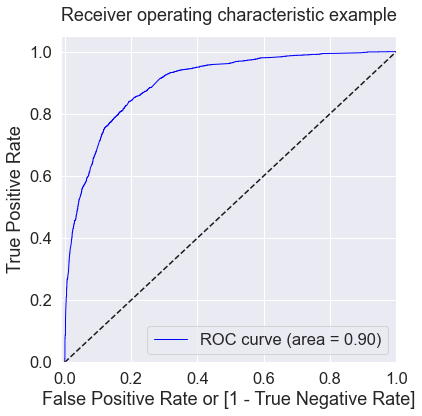

In [124]:
draw_roc(y_train_pred_final.Converted,y_train_pred_final.Converted_Probablity)

### Creating prediction at different probabiliites

In [125]:
prbs = [x/10 for x in range(10)]
for i in prbs:
    y_train_pred_final[i] = y_train_pred_final.Converted_Probablity.map(lambda x: 1 if x>i else 0)
    
y_train_pred_final.head()

,Converted,Converted_Probablity,Lead Number,Predicted_Conversion,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.168309,613099,0,1,1,0,0,0,0,0,0,0,0
1,0,0.051655,647994,0,1,0,0,0,0,0,0,0,0,0
2,0,0.753150,658071,1,1,1,1,1,1,1,1,1,0,0
3,1,0.869735,592424,1,1,1,1,1,1,1,1,1,1,0
4,0,0.093771,607745,0,1,0,0,0,0,0,0,0,0,0


In [126]:
## Calculating the Accuracy Sensitivity and Specificity for each of the probabilites
metrics_df = pd.DataFrame(columns = ['Probability','Accuracy','Sensitivity','Specificity'])

for i in prbs:
    cnfsn = metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final[i])
    tn = cnfsn[0,0]
    fp = cnfsn[0,1]
    tp = cnfsn[1,1]
    fn = cnfsn[1,0]
    total = tn+fp+tp+fn
    acrcy = (tp+tn)/total
    sensi = tp/(tp+fn)
    speci = tn/(tn+fp)
    
    metrics_df.loc[i] = [i,acrcy,sensi,speci]

metrics_df

,Probability,Accuracy,Sensitivity,Specificity
0.0,0.0,0.387291,1.000000,0.000000
0.1,0.1,0.648423,0.972854,0.443351
0.2,0.2,0.779839,0.931337,0.684078
0.3,0.3,0.806277,0.863473,0.770124
0.4,0.4,0.825139,0.789621,0.847590
0.5,0.5,0.828850,0.741317,0.884179
0.6,0.6,0.814007,0.655090,0.914459
0.7,0.7,0.797774,0.566866,0.943729
0.8,0.8,0.770408,0.457086,0.968458
0.9,0.9,0.718769,0.291417,0.988897


#### Plotting the accuracy sensitivity and specificity values to get a optimal cuttoff point

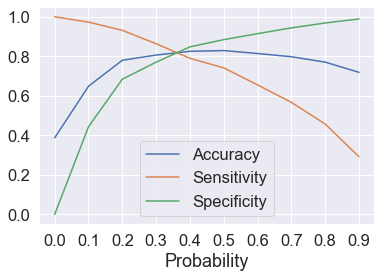

In [127]:
metrics_df.plot.line(x='Probability',y=['Accuracy','Sensitivity','Specificity'])
plt.xticks(ticks = [x/10 for x in range(10)])
plt.show()

#### From the curve above, 0.36 is the optimum point to take it as a cutoff probability.

In [128]:
y_train_pred_final['Final_Predicted_Conversion'] = y_train_pred_final.Converted_Probablity.map(lambda x: 1 if x>0.36 else 0)
y_train_pred_final.head()

,Converted,Converted_Probablity,Lead Number,Predicted_Conversion,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final_Predicted_Conversion
0,0,0.168309,613099,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.051655,647994,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.753150,658071,1,1,1,1,1,1,1,1,1,0,0,1
3,1,0.869735,592424,1,1,1,1,1,1,1,1,1,1,0,1
4,0,0.093771,607745,0,1,0,0,0,0,0,0,0,0,0,0


# Evaluating the final model

In [129]:
confusion_final = metrics.confusion_matrix(y_train_pred_final.Converted,y_train_pred_final.Final_Predicted_Conversion)
confusion_final

array([[3266,  697],
       [ 467, 2038]], dtype=int64)

In [130]:
## True Negative, False Positive, True Positive and False Negative
TNf = confusion_final[0,0]
FPf = confusion_final[0,1]
TPf = confusion_final[1,1]
FNf = confusion_final[1,0]

In [131]:
## Final accuracy score
accuracy_final = round(metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.Final_Predicted_Conversion),3)
accuracy_final

0.82

#### Sensitivity of the final model

In [132]:
Sensitivity_Final = TPf/(TPf+FNf)
round(Sensitivity_Final,2)

0.81

#### Specificity of the final model

In [133]:
Specificity_Final = TNf/(TNf+FPf)
round(Specificity_Final,2)

0.82

#### False positive rate of the final model

In [134]:
Final_FPR = FPf/(TNf+FPf)
round(Final_FPR,2)

0.18

#### Positive Predictive Value of the final model

In [135]:
Final_PPV = TPf/(TPf+FNf)
round(Final_PPV,2)

0.81

#### Negative Predictive Value of the final model

In [136]:
Final_NPV = TNf/(TNf+FPf)
round(Final_NPV,2)

0.82

# Calculating the Precision and Recall

In [137]:
#### Precision

In [138]:
final_precision = metrics.precision_score(y_train_pred_final.Converted,y_train_pred_final.Final_Predicted_Conversion)
final_precision

0.7451553930530165

In [139]:
final_recall = metrics.recall_score(y_train_pred_final.Converted,y_train_pred_final.Final_Predicted_Conversion)
final_recall

0.8135728542914171

### Precision and recall tradeoff

In [140]:
p,r,thresholds = precision_recall_curve(y_train_pred_final.Converted,y_train_pred_final.Converted_Probablity)

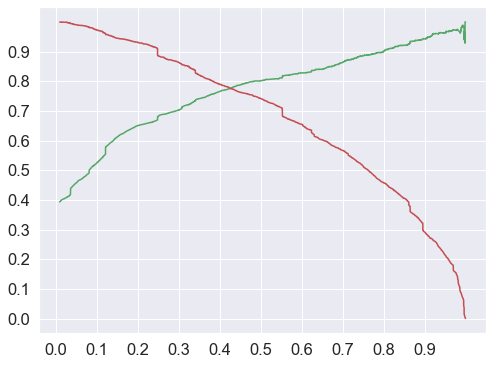

In [141]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(ticks = [x/10 for x in range(10)])
plt.yticks(ticks = [x/10 for x in range(10)])
plt.show()

## Predicting on the Test Data

In [142]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [143]:
X_test = X_test[col]
X_test.shape

(2772, 13)

### Predicting y on test data

In [144]:
y_test_pred = res.predict(sm.add_constant(X_test))

In [145]:
y_test_pred

Lead Number
620113    0.029895
610779    0.189333
609385    0.001836
629371    0.325870
611662    0.992965
            ...   
643897    0.996118
640032    0.761166
594521    0.995374
658023    0.598722
600861    0.034475
Length: 2772, dtype: float64

In [146]:
y_test_pred_df = pd.DataFrame(y_test_pred)
y_test_pred_df = y_test_pred_df.rename(columns = {0:'Conversion_Probability'})
y_test_pred_df

,Conversion_Probability
Lead Number,
620113,0.029895
610779,0.189333
609385,0.001836
629371,0.325870
611662,0.992965
...,...
643897,0.996118
640032,0.761166
594521,0.995374


In [147]:
y_test_df = pd.DataFrame(y_test)
y_test_df['Lead Number'] = y_test_df.index
y_test_df

,Converted,Lead Number
Lead Number,,
620113,0,620113
610779,0,610779
609385,0,609385
629371,0,629371
611662,1,611662
...,...,...
643897,1,643897
640032,0,640032
594521,1,594521


#### Removing the index on both the y_test_df and y_test_pred_df dataframes

In [148]:
y_test_df.reset_index(drop=True,inplace=True)
y_test_pred_df.reset_index(drop=True,inplace=True)

In [149]:
y_test_final = pd.concat([y_test_df,y_test_pred_df],axis=1)
y_test_final.head()

,Converted,Lead Number,Conversion_Probability
0,0,620113,0.029895
1,0,610779,0.189333
2,0,609385,0.001836
3,0,629371,0.325870
4,1,611662,0.992965


In [150]:
# Rearranging the columns
y_test_final = y_test_final.reindex(['Lead Number','Converted','Conversion_Probability'], axis=1)

In [151]:
y_test_final['Final_Predicted'] = y_test_final['Conversion_Probability'].map(lambda x: 1 if x>0.36 else 0)
y_test_final

,Lead Number,Converted,Conversion_Probability,Final_Predicted
0,620113,0,0.029895,0
1,610779,0,0.189333,0
2,609385,0,0.001836,0
3,629371,0,0.325870,0
4,611662,1,0.992965,1
...,...,...,...,...
2767,643897,1,0.996118,1
2768,640032,0,0.761166,1
2769,594521,1,0.995374,1
2770,658023,0,0.598722,1


## Checking the metrics of the predications made.

#### Accuracy Score

In [152]:
#### Accuracy Score
accuracy_test = metrics.accuracy_score(y_test_final.Converted,y_test_final.Final_Predicted)
accuracy_test

0.8134920634920635

#### Confustion matrix

In [154]:
confusion_test = metrics.confusion_matrix(y_test_final.Converted,y_test_final.Final_Predicted)
confusion_test

array([[1415,  301],
       [ 216,  840]], dtype=int64)

In [155]:
TNt = confusion_test[0,0]
FPt = confusion_test[0,1]
TPt = confusion_test[1,1]
FNt = confusion_test[1,0]

#### Sensitivity of the prediction in test data

In [156]:
Sensitivity_Test = TPt/(TPt+FNt)
print('Sensitivity %:',round(Sensitivity_Test,2)*100)

Sensitivity %: 80.0


#### Specificity of the prediction in test data

In [157]:
Specificity_Test = TNt/(TNt+FPt)
print('Specificity %:',round(Specificity_Test,2)*100)

Specificity %: 82.0


#### Precision score on the the test data

In [159]:
precision_test = metrics.precision_score(y_test_final.Converted,y_test_final.Final_Predicted)
print('Precision %:',round(precision_test,2)*100)

Precision %: 74.0


#### Recall score on the test data

In [161]:
recall_test = metrics.recall_score(y_test_final.Converted,y_test_final.Final_Predicted)
print('Recall %:',round(recall_test,2)*100)

Recall %: 80.0


#### Calculating the F1 score of the model on the test data
#### F1 = 2 * (precision * recall) / (precision + recall)

In [172]:
F1 = 2*((precision_test*recall_test)/(precision_test+recall_test))
print('F1 score:',round(F1,2))

F1 score: 0.76


### Assigning a Lead Score to each lead


In [162]:
y_test_final['Lead_Score'] = y_test_final.Conversion_Probability.map(lambda x : round(x*100,2))

In [163]:
y_test_final.head()

,Lead Number,Converted,Conversion_Probability,Final_Predicted,Lead_Score
0,620113,0,0.029895,0,2.99
1,610779,0,0.189333,0,18.93
2,609385,0,0.001836,0,0.18
3,629371,0,0.325870,0,32.59
4,611662,1,0.992965,1,99.30


## Assignment subjective questions

__1. Which are the top three variables in your model which contribute most towards the probability of a lead getting converted?__

In [164]:
res.params.sort_values(ascending=False)

Total Time Spent on Website                             4.562511
TotalVisits                                             4.246174
Lead Source_Welingak Website                            3.439851
Lead Origin_Lead Add Form                               3.168093
What is your current occupation_Working Professional    2.081266
Lead Source_Olark Chat                                  1.526456
Last Activity_SMS Sent                                  1.319767
What is your current occupation_Other                  -0.873311
const                                                  -1.021504
Lead Profile_Other Leads                               -1.235591
Last Activity_Olark Chat Conversation                  -1.319563
Do Not Email                                           -1.436613
Lead Profile_Not Selected                              -1.614412
Lead Profile_Student of SomeSchool                     -4.058225
dtype: float64

__From the co-efficients for the features we can infer that the below features contribute most towards the probability of a lead getting converted__ 

__1.Total Time Spent on Website__\
__2.TotalVisits__\
__3.Lead Source_Welingak Website__

__-----------------------------------------------------------------------------------------------------__

__2.	What are the top 3 categorical/dummy variables in the model which should be focused the most on in order to increase the probability of lead conversion?__

__The top 3 categorical/dummy variables in the model which should be focused the most on in order to increase the probability of lead conversion__\

__1.Lead Source_Welingak Website__\
__2.Lead Origin_Lead Add Form__\
__3.What is your current occupation_Working Professional__